In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Required Libraries

In [ ]:
# Install required
!pip install transformers datasets evaluate accelerate -q

# Import

In [ ]:
import os
import numpy as np
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [ ]:
# Save files here
model_artifacts = "/content/drive/MyDrive/Colab Notebooks/Cyberbullying/models/distilBERT"

# 1. Load & Prepare Dataset



In [ ]:
# Load dataset from HF repo
datas = load_dataset("cike-dev/en_toxic_set")

# Convert train split to pandas
df_train = datas["train"].to_pandas()
print("\nTrain set shape:", df_train.shape)

# Convert validation split to pandas
df_val = datas["validation"].to_pandas()
print("\nValidation set shape:", df_val.shape)

# Convert test split to pandas
df_test = datas["validation"].to_pandas()
print("\nValidation set shape:", df_test.shape)

# Encode labels: normal=0, toxic=1
df_train["label"] = df_train["label"].apply(lambda x: 1 if x == "toxic" else 0)
df_val["label"] = df_val["label"].apply(lambda x: 1 if x == "toxic" else 0)
df_valtest["label"] = df_test["label"].apply(lambda x: 1 if x == "toxic" else 0)

# Rename text column
df_train = df_train.rename(columns={"cleaned_text": "text"})
df_val = df_val.rename(columns={"cleaned_text": "text"})
df_test = df_test.rename(columns={"cleaned_text": "text"})

# # Split validation set 50/50 into test and eval
# df_test, df_val = train_test_split(
#     df_valtest, test_size=0.5, random_state=42, stratify=df_valtest["label"]
# )

# Convert back to Hugging Face Datasets
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test),
    "validation": Dataset.from_pandas(df_val)

    # to avoid __index_level_0__ issues:
    # "test": Dataset.from_pandas(df_test, preserve_index=False),
    # "validation": Dataset.from_pandas(df_val, preserve_index=False)
})

# Remove the extra index column from test/validation
ds["test"] = ds["test"].remove_columns("__index_level_0__")
ds["validation"] = ds["validation"].remove_columns("__index_level_0__")

print("\n", ds)



Train set shape: (76259, 2)

Validation set shape: (9522, 2)

 DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 76259
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4761
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4761
    })
})


### Plot 'train' set info

In [ ]:
df_train

,text,label
0,oh and the 3rd song too .,0
1,the definition of traitor is then the issue s...,0
2,ants can create their own civilization because...,0
3,not that i have tried it but pointing at eithe...,1
4,maybe.,0
...,...,...
76254,we have a free market in america muh....,0
76255,thirsty fo da bitches saggin my pants n shit ....,1
76256,christian cake baker who won scotus case is no...,1
76257,i had to get used to her looking like that bec...,0


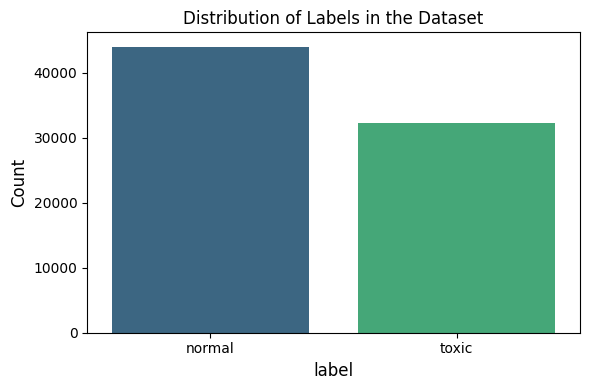

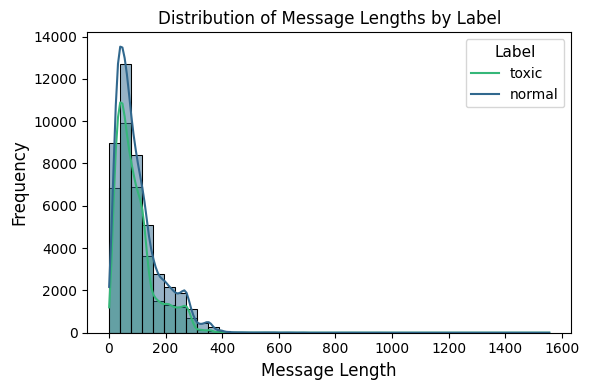

In [ ]:
# Plot 1: Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x='label', hue='label', palette='viridis', legend=False) # Modified for warning
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['normal', 'toxic']) # Adjusted labels
plt.tight_layout()
plt.savefig(f'{model_artifacts}/ft-dbert-label_distribution.png')
plt.show()
plt.close()



# Plot 2: Message Length Distribution for Each Class

# Calculate message lengths
df_train['message_length'] = df_train['text'].apply(len)
print()


plt.figure(figsize=(6, 4))

# Reduce bins & add transparency
sns.histplot(
    data=df_train,
    x='message_length',
    hue='label',
    kde=True,
    palette='viridis',
    common_norm=False,
    bins=40,         # fewer bins = smoother hist
    alpha=0.5        # transparency
)

# Titles and labels
# plt.title('Distribution of Message Lengths by Label', fontsize=14, weight='bold')
plt.title('Distribution of Message Lengths by Label')
plt.xlabel('Message Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Fix legend
plt.legend(title='Label', labels=['toxic', 'normal'], fontsize=10, title_fontsize=11)

# Tighter layout
plt.tight_layout()
plt.savefig(f"{model_artifacts}/length_dist.png", dpi=300)
plt.show()
plt.close()

# Drop the temporary 'message_length' column
df_train = df_train.drop(columns=['message_length'])


# 2. Tokenization and Preprocessing

Using dynamic padding later via data collator,  
so we don’t pad here to max across entire dataset.

In [ ]:
model_checkpoint = "distilbert/distilbert-base-uncased"  # or another base model you prefer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_fn(examples):
    # truncation ensures sequences fit the model max length
    return tokenizer(examples["text"], truncation=True, padding=False)

tokenized = ds.map(preprocess_fn, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/76259 [00:00<?, ? examples/s]

Map:   0%|          | 0/4761 [00:00<?, ? examples/s]

Map:   0%|          | 0/4761 [00:00<?, ? examples/s]

# 3. Data Collator

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# 4. Define Metrics

In [ ]:
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    prec = precision.compute(predictions=preds, references=labels, average="binary")
    rec = recall.compute(predictions=preds, references=labels, average="binary")
    f1score = f1.compute(predictions=preds, references=labels, average="binary")
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1score["f1"],
    }

# 5. Model + Label Mapping

In [ ]:
id2label = {0: "normal", 1: "toxic"}
label2id = {"normal": 0, "toxic": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 6. Training Arguments

These hyperparameters are generally strong for text classification tasks

In [ ]:
training_args = TrainingArguments(
    output_dir=f"{model_artifacts}/distilbert_toxic",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=16,       # depending on GPU — maybe 32 if you can
    per_device_eval_batch_size=32,
    num_train_epochs=4,                   # you can try 3-5
    learning_rate=2e-5,                   # a common fine-tune LR
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",            # 10% warm-up
    load_best_model_at_end=True,
    metric_for_best_model="f1",           # often best measure in imbalanced data
    greater_is_better=True,
    save_total_limit=2,                   # keep only top 2
    fp16=True,                            # if using GPU with mixed precision support
    gradient_accumulation_steps=1,        # increase if batch size small
    seed=3407,
    report_to="none"
)

In [ ]:
# # List of all training arguments for this trainer config
# trainer.args

## 7. Trainer Initialization and Training

In [ ]:
# Initualize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


# train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.297100,0.325756,0.867465,0.864308,0.814023,0.838412
2,0.279800,0.312035,0.870825,0.845203,0.849826,0.847508
3,0.148100,0.389807,0.868095,0.846617,0.839881,0.843235
4,0.116100,0.504827,0.861164,0.846865,0.819493,0.832954


TrainOutput(global_step=19068, training_loss=0.24118302572141134, metrics={'train_runtime': 996.4046, 'train_samples_per_second': 306.137, 'train_steps_per_second': 19.137, 'total_flos': 4875935557543344.0, 'train_loss': 0.24118302572141134, 'epoch': 4.0})

In [ ]:

# Save the model to local
save_dir = f"{model_artifacts}/toxic-FineTuned"
trainer.save_model(save_dir)           # saves model + config
tokenizer.save_pretrained(save_dir)    # saves tokenizer


# Push to HF
from huggingface_hub import HfFolder, Repository
repo_name = "cike-dev/Distilbert_toxic"
trainer.push_to_hub(repo_name)
# model.push_to_hub(repo_name)
# tokenizer.push_to_hub(repo_name)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  .../distilbert_toxic/model.safetensors:   0%|          |  574kB /  268MB            

  .../distilbert_toxic/training_args.bin:   1%|          |  49.0B / 5.91kB            

CommitInfo(commit_url='https://huggingface.co/cike-dev/distilbert_toxic/commit/a044f621dfa92ba95490d1a6e5af13b11afe59a7', commit_message='cike-dev/Distilbert_toxic', commit_description='', oid='a044f621dfa92ba95490d1a6e5af13b11afe59a7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/cike-dev/distilbert_toxic', endpoint='https://huggingface.co', repo_type='model', repo_id='cike-dev/distilbert_toxic'), pr_revision=None, pr_num=None)

## 8. Evaluation and Inference

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.31203508377075195, 'eval_accuracy': 0.870825456836799, 'eval_precision': 0.8452027695351138, 'eval_recall': 0.8498259572352064, 'eval_f1': 0.8475080585172329, 'eval_runtime': 2.8852, 'eval_samples_per_second': 1650.169, 'eval_steps_per_second': 51.644, 'epoch': 4.0}


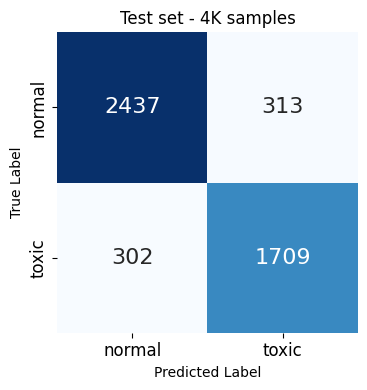

In [ ]:
# Get predictions on validation set
predictions = trainer.predict(tokenized["validation"])

# Get predicted labels (argmax of logits)
y_pred = np.argmax(predictions.predictions, axis=1)

# Get true labels
y_true = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["normal", "toxic"])
# disp.plot(cmap=plt.cm.Blues, colorbar=False)  # 👈 turn off colorbar
# plt.title("Test set Confusion Matrix")
# plt.yticks(rotation=90)   # 👈 make y-axis labels vertical
# plt.tight_layout()
# plt.show()


# Plot with seaborn
plt.figure(figsize=(5,4))   # make it square
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,   # no colorbar
    square=True,  # 👈 ensures square cells
    xticklabels=["normal", "toxic"],
    yticklabels=["normal", "toxic"],
    annot_kws={"size": 16}  # 👈 control font size & style
    # annot_kws={"size": 16, "weight": "bold"}  # 👈 control font size & style
)

plt.title("Test set - 4K samples")
plt.yticks(rotation=90, fontsize=12) # y-axis vertical
plt.xticks(fontsize=12)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(f"{model_artifacts}/confusion_matrix.png")
plt.show()
plt.close()

#### Inference via transformers.pipeline library

In [ ]:
from transformers import pipeline

# Load your trained cyberbullying model
pipe = pipeline(
    task="text-classification",
    model=trainer.model,
    tokenizer=tokenizer,
    # model="/content/drive/MyDrive/Colab Notebooks/Cyberbullying/models/distilBERT/cyberbullying-distilbert",
    # tokenizer="distilbert-base-uncased"

)

# Run inference
print(pipe("You are stupid", top_k=None))  # returns scores for both toxic and norm
print('\n',pipe("You are amazing!", top_k=1))   # returns just the top prediction


Device set to use cuda:0


[{'label': 'toxic', 'score': 0.9379537105560303}, {'label': 'normal', 'score': 0.06204626336693764}]

 [{'label': 'normal', 'score': 0.9971272349357605}]


## Local Inference with the Uploaded Model

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="cike-dev/DistilbertBullyClassifier")
print(pipe("You are such an idiot!"))


config.json:   0%|          | 0.00/673 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'toxic', 'score': 0.9521245956420898}]
